# CNN Transfer Learning on Cats-Dogs Classification

### VGG16 trained on ImageNet data is used as pre-trained model from which to extract features.  Features are then saved, and passed through neural network with ReLu hidden layer to classify cats vs. dogs.

#### Adapted from fchollet/classifier_from_little_data_script_2.py (https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069) and blog https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense
from keras import backend as K
from keras import applications
import numpy as np

In [3]:
import tensorflow as tf
print (tf.__version__)
print (keras.__version__)

1.14.0
2.2.4


In [4]:
# Set logging level
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
# Set random generator seed
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

### Set dimensions, number, and location of images

In [6]:
# Image dimensions
img_width, img_height = 150, 150

# Location of images
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
print (input_shape)

# Number of images
nb_train_samples = 2000
nb_validation_samples = 800

# Batch size
batch_size = 16

(150, 150, 3)


### Extract features from pre-trained network and save features

In [7]:
def save_features():
    
    # Scale pixel values in image
    datagen = ImageDataGenerator(rescale=1. / 255)

    # Load the VGG16 network's imagenet weights, not including the last fully connected layers.
    model = applications.VGG16(include_top=False, weights='imagenet')

    # Generator that will read pictures found in subfolders of training data directory,
    # and indefinitely generate batches of image data (scaled)
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,        # Generator will only yield batches of data, no labels
        shuffle=False)          # Data will be presented in order, i.e., 1000 cat images, then 1000 dog images
    
    # The predict_generator method returns the output of the model, given input provided by a generator
    # that yields batches of numpy data
    features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    # Save model outputs (i.e., features) from model as numpy array
    np.save('features_train.npy', features_train) 

    # Generator to generator validation input for model
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    # Get model output for validation data
    features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    
    # Save model outputs (i.e., features) for validation data
    np.save('features_validation.npy', features_validation) 
    
    # Print out model architecture
    model.summary()

In [8]:
save_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
___________________________________________________________

### Load saved features

In [9]:
# Load saved features for train data
train_data = np.load('features_train.npy')
    
# Create labels for train data.  Images were generated in order, so creating labels is easy.
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2)) 

# Load saved features for validation data
validation_data = np.load('features_validation.npy') 
    
# Create labels for validation data
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2)) 
    
print (train_labels.shape, validation_labels.shape)

(2000,) (800,)


### Create top model

In [10]:
# Create fully connected layer on top of model
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))  # Convert 3D feature maps to 1D feature vectors
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# Create model
top_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', 
              metrics=['accuracy'])
print(top_model)
top_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


### Train top model

In [11]:
# Set up model
epochs = 50

# Train model, keeping track of history
from keras.callbacks import History
hist = top_model.fit(train_data, train_labels,
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s 451us/step - loss: 0.7173 - acc: 0.7445 - val_loss: 0.2955 - val_acc: 0.8788
Epoch 2/50
2000/2000 [==============================] - 1s 262us/step - loss: 0.3366 - acc: 0.8525 - val_loss: 0.2619 - val_acc: 0.8925
Epoch 3/50
2000/2000 [==============================] - 1s 262us/step - loss: 0.2733 - acc: 0.8930 - val_loss: 0.2399 - val_acc: 0.9000
Epoch 4/50
2000/2000 [==============================] - 1s 262us/step - loss: 0.2335 - acc: 0.9060 - val_loss: 0.2654 - val_acc: 0.9050
Epoch 5/50
2000/2000 [==============================] - 1s 262us/step - loss: 0.1953 - acc: 0.9210 - val_loss: 0.2883 - val_acc: 0.9025
Epoch 6/50
2000/2000 [==============================] - 1s 264us/step - loss: 0.2014 - acc: 0.9205 - val_loss: 0.2499 - val_acc: 0.9025
Epoch 7/50
2000/2000 [==============================] - 1s 261us/step - loss: 0.1649 - acc: 0.9355 - val_loss: 0.2898 - val_acc: 0.9025
E

### Save model and weights

In [12]:
# Save model & weights to HDF5 file
top_model_file = 'features_model' 
top_model.save(top_model_file + '.h5')

# Save model to JSON file & weights to HDF5 file
top_model_json = top_model.to_json()
with open(top_model_file + '.json','w') as json_file:
    json_file.write(top_model_json)
top_model.save_weights(top_model_file+'-wts.h5')

# Results on validation set
print (top_model.metrics_names)
results = top_model.evaluate (validation_data, validation_labels)
print (results)

['loss', 'acc']
800/800 [==============================] - 0s 44us/step
[0.9517863084282726, 0.9025]


### Load model again and test

In [13]:
top_model2 = keras.models.load_model(top_model_file+'.h5')
print (validation_labels.shape)

print (top_model2.metrics_names)
results = top_model2.evaluate(validation_data, validation_labels)
print (results)

(800,)
['loss', 'acc']
800/800 [==============================] - 0s 109us/step
[0.9517863084282726, 0.9025]


### Print training history

In [14]:
print (hist.history)

{'val_loss': [0.29550837591290474, 0.2619392427802086, 0.2399297235161066, 0.26536471109837295, 0.2883329723030329, 0.24992597851902246, 0.2897954322583973, 0.31217764580622315, 0.3352208779472858, 0.39801991593674757, 0.3547872976027429, 0.3922950893314555, 0.4283073475700803, 0.4469229808205273, 0.47171028133336224, 0.44378503117128276, 0.46315815157373436, 0.6482554030558458, 0.5530002697507734, 0.6337780241169457, 0.6251263874844881, 0.9545960466647228, 0.819805117763226, 0.8321390694003117, 0.7046007916537246, 0.7247405769681382, 0.8311344434639375, 0.7168575236459764, 0.7572092972567543, 0.7354465282154433, 0.77146533300275, 0.811268423377295, 0.7492962822355139, 0.685479663200149, 0.7339621196353073, 0.8529876519172365, 0.8069830911780537, 0.8029036299770929, 0.934992543977661, 0.8392762804153461, 0.8568554513889217, 0.8934931571906575, 0.9892102050986058, 0.8284352308381085, 0.9492261414801691, 0.9886890852915429, 0.9613967794786484, 0.8984629733809482, 1.0154269373450842, 0.95

### Plot performance metrics

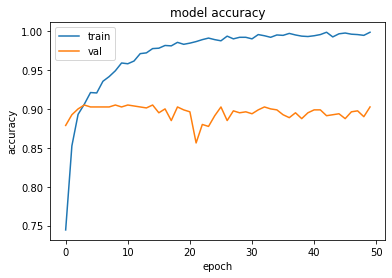

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

result = hist.history

# summarize history for accuracy
plt.plot(result['acc'])
plt.plot(result['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()